In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image 
pd.options.display.max_columns=15
import seaborn as sns

In [3]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\AAM\Clustering")
seed = 4

In [4]:
df = pd.read_csv(os.getcwd()+r"\Data Files\NVHGearsBLCarrier.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,SITENAME,PLANTNAME,LINENAME,STATIONNAME,LAPPER_STATION,BACKLASH_STATION,OP110_STN,...,'SFT 1st Mesh Harmonic Coast Side Pos 1 Val (µrad)','Single Flank Tester Spiral Angle Pinion','Single Flank Tester Spiral Angle Ring Gear',M46BPDXX_DISTANCE_D_SEAT_TO_FG,M47BPDXX_DISTANCE_DE_TO_F_SEAT,M48BPDXX_DISTANCE_DE_TO_G_SEAT,PERP_OF_AXIS_DAT_FG_TO_AXIS_DAT_DE_DAT_B_TWO_COAXIAL_HOLES
0,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300A,GBT604077,B,110B,...,3.0684,51.083,25.066,158.5025,142.5115,105.0310,0.06390
1,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300A,GBT702432,A,110B,...,3.1568,51.083,25.066,158.4980,142.4870,105.0190,0.00880
2,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300B,GBT702432,A,110B,...,3.6532,51.083,25.066,158.4850,142.4860,105.0425,0.01305
3,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300B,GBT604077,A,110A,...,2.0519,51.083,25.066,158.5055,142.4780,105.0230,0.02975
4,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300A,GBT604077,A,110A,...,0.5989,51.083,25.066,158.4710,142.5160,105.0750,0.05240


# Data Cleaning

In [6]:
df["STATUS_ENC"]=np.where(df["STATUS"]=='A',0,1)

In [7]:
df["'Pinion Position'"] = df["'Pinion Position'"].fillna(df.groupby('TOPPART')["'Pinion Position'"].transform('median'))
df["'Pinion Head dist real'"] = df["'Pinion Head dist real'"].fillna(df.groupby('TOPPART')["'Pinion Head dist real'"].transform('median'))
df["'Single Flank Tester Spiral Angle Pinion'"] = df["'Single Flank Tester Spiral Angle Pinion'"].fillna(df.groupby(['LAPPER_STATION'])["'Single Flank Tester Spiral Angle Pinion'"].transform('median'))
df["'Single Flank Tester Spiral Angle Ring Gear'"] = df["'Single Flank Tester Spiral Angle Ring Gear'"].fillna(df.groupby(['LAPPER_STATION'])["'Single Flank Tester Spiral Angle Ring Gear'"].transform('median'))

In [8]:
df.dropna(inplace = True)

# Select TopPart

In [9]:
df_model = df[df["TOPPART"]==84833854]

# Create Story

### 1st method: Assign bad rate: lowest of both the sides 

In [45]:
def cost(df = pd.DataFrame(), feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = 0):
    dist1 = df_model[df_model[feature]>cutoff][[feature,status_enc]]
    dist2 = df_model[df_model[feature]<=cutoff][[feature,status_enc]]


    bad_rate1= dist1[status_enc].sum()/dist1[status_enc].count()
    bad_rate2= dist2[status_enc].sum()/dist2[status_enc].count()

    bad_ratef = np.minimum(bad_rate1, bad_rate2)

    reject_saving = round((bad_rate1-bad_ratef) * dist1[status_enc].count() + (bad_rate2-bad_ratef) * dist2[status_enc].count())

    return reject_saving

In [46]:
cost_df = {'cutoff':[],'reject_saving':[]}
for cut in df["'Ring Gear Press Distance'"].quantile(np.arange(0,1,0.02)):
    cost_df["cutoff"].append(cut)
    cost_df["reject_saving"].append(cost(df = df_model, feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = cut))
    
cost_df = pd.DataFrame(cost_df)

<AxesSubplot:xlabel='cutoff'>

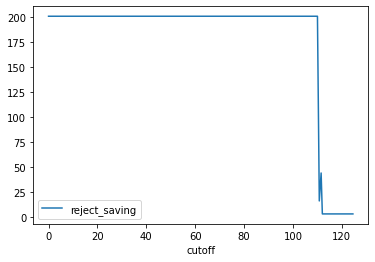

In [48]:
cost_df.plot(x='cutoff',y='reject_saving')

<AxesSubplot:>

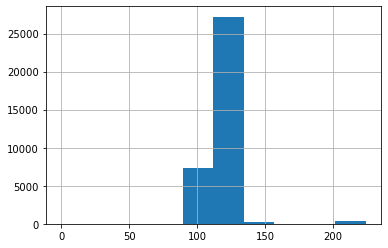

In [14]:
df_model[feature].hist()

### 2nd Analysis: Assign Bad rate: Of the side with higher observations

In [23]:
def cost(df = pd.DataFrame(), feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = 0):
    dist1 = df_model[df_model[feature]>cutoff][[feature,status_enc]]
    dist2 = df_model[df_model[feature]<=cutoff][[feature,status_enc]]


    bad_rate1= dist1[status_enc].sum()/dist1[status_enc].count()
    bad_rate2= dist2[status_enc].sum()/dist2[status_enc].count()

    bad_ratef = np.where(dist1[status_enc].count()>dist2[status_enc].count(),bad_rate1, bad_rate2)

    reject_saving = round((bad_rate1-bad_ratef) * dist1[status_enc].count() + (bad_rate2-bad_ratef) * dist2[status_enc].count())

    return reject_saving

In [36]:
cost_df = {'cutoff':[],'reject_saving':[]}
for cut in df["'Ring Gear Press Distance'"].quantile(np.arange(0,1,0.02)):
    cost_df["cutoff"].append(cut)
    cost_df["reject_saving"].append(cost(df = df_model, feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = cut))
    
cost_df = pd.DataFrame(cost_df)

<AxesSubplot:xlabel='cutoff'>

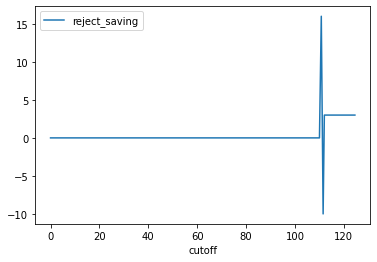

In [37]:
cost_df.plot(x='cutoff',y='reject_saving')

In [30]:
cost(df = df_model, feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = 111)

16.0

### 3rd Analysis: Use Accuracy

In [56]:
def cost(df = pd.DataFrame(), feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = 0):
    
    
    dist1 = df_model[df_model[feature]>cutoff][[feature,status_enc]]
    dist2 = df_model[df_model[feature]<=cutoff][[feature,status_enc]]

    bad_rate_overall = df_model[status_enc].sum()/df_model[status_enc].count()
    bad_rate1= dist1[status_enc].sum()/dist1[status_enc].count()
    bad_rate2= dist2[status_enc].sum()/dist2[status_enc].count()

#     if bad_rate1 > bad_rate_overall :
#         accuracy1 = dist1[status_enc].sum()/dist1[status_enc].count()
#     else:
#         accuracy1 = 1-dist1[status_enc].sum()/dist1[status_enc].count()
    
#     if bad_rate2 > bad_rate_overall :
#         accuracy2 = dist2[status_enc].sum()/dist2[status_enc].count()
#     else:
#         accuracy2 = 1-dist2[status_enc].sum()/dist2[status_enc].count()
    
    if bad_rate1 > 0.5 :
        accuracy1 = bad_rate1
    else:
        accuracy1 = 1-bad_rate1
    
    if bad_rate2 > 0.5 :
        accuracy2 = bad_rate1
    else:
        accuracy2 = bad_rate2
      
  
    weighted_accuracy = (accuracy1*dist1[status_enc].count()+accuracy2*dist2[status_enc].count())/(df_model[status_enc].count())
    bad_ratef = np.minimum(bad_rate1, bad_rate2)

    reject_saving = round((bad_rate1-bad_ratef) * dist1[status_enc].count() + (bad_rate2-bad_ratef) * dist2[status_enc].count())


    return reject_saving, weighted_accuracy

In [57]:
cost_df = {'cutoff':[],'reject_saving':[], 'weighted_acc':[]}
for cut in df["'Ring Gear Press Distance'"].quantile(np.arange(0,1,0.02)):
    reject_saving, weighted_accuracy = cost(df = df_model, feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = cut)
    cost_df["cutoff"].append(cut)
    cost_df["reject_saving"].append(reject_saving)
    cost_df["weighted_acc"].append(weighted_accuracy)
    
cost_df = pd.DataFrame(cost_df)

(100.0, 120.0)

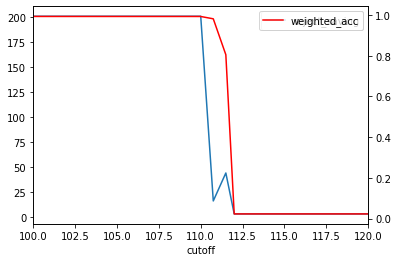

In [58]:
ax = cost_df.plot(x='cutoff',y=['reject_saving'])
ax1 = ax.twinx()
cost_df.plot(x='cutoff',y=['weighted_acc'],ax=ax1, color='r')
plt.xlim(100,120)

In [59]:
def cost(df = pd.DataFrame(), feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = 0):
    
    
    dist1 = df_model[df_model[feature]>cutoff][[feature,status_enc]]
    dist2 = df_model[df_model[feature]<=cutoff][[feature,status_enc]]

    bad_rate_overall = df_model[status_enc].sum()/df_model[status_enc].count()
    bad_rate1= dist1[status_enc].sum()/dist1[status_enc].count()
    bad_rate2= dist2[status_enc].sum()/dist2[status_enc].count()

    if bad_rate1 > bad_rate_overall :
        accuracy1 = dist1[status_enc].sum()/dist1[status_enc].count()
    else:
        accuracy1 = 1-dist1[status_enc].sum()/dist1[status_enc].count()
    
    if bad_rate2 > bad_rate_overall :
        accuracy2 = dist2[status_enc].sum()/dist2[status_enc].count()
    else:
        accuracy2 = 1-dist2[status_enc].sum()/dist2[status_enc].count()
    
#     if bad_rate1 > 0.5 :
#         accuracy1 = bad_rate1
#     else:
#         accuracy1 = 1-bad_rate1
    
#     if bad_rate2 > 0.5 :
#         accuracy2 = bad_rate1
#     else:
#         accuracy2 = bad_rate2
      
  
    weighted_accuracy = (accuracy1*dist1[status_enc].count()+accuracy2*dist2[status_enc].count())/(df_model[status_enc].count())
    bad_ratef = np.minimum(bad_rate1, bad_rate2)

    reject_saving = round((bad_rate1-bad_ratef) * dist1[status_enc].count() + (bad_rate2-bad_ratef) * dist2[status_enc].count())


    return reject_saving, weighted_accuracy

In [60]:
cost_df = {'cutoff':[],'reject_saving':[], 'weighted_acc':[]}
for cut in df["'Ring Gear Press Distance'"].quantile(np.arange(0,1,0.02)):
    reject_saving, weighted_accuracy = cost(df = df_model, feature = "'Ring Gear Press Distance'", status = "STATUS_ENC", cutoff = cut)
    cost_df["cutoff"].append(cut)
    cost_df["reject_saving"].append(reject_saving)
    cost_df["weighted_acc"].append(weighted_accuracy)
    
cost_df = pd.DataFrame(cost_df)

(100.0, 120.0)

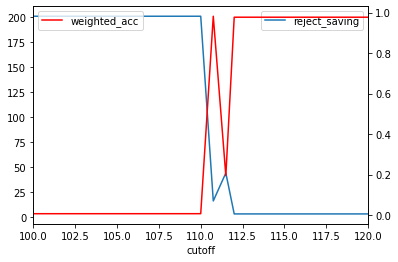

In [61]:
ax = cost_df.plot(x='cutoff',y=['reject_saving'])
ax1 = ax.twinx()
cost_df.plot(x='cutoff',y=['weighted_acc'],ax=ax1, color='r')
plt.xlim(100,120)

### compare with Decision Tree (gini)